In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import joblib
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# considering the following possibilities: Decision Trees, RandomForest, Xgboost, MLPN, Support Vector Machines
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm

# cross validation for HP
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Feature selection
from sklearn.feature_selection import SelectKBest, f_classif
#from sklearn.feature_selection import ch2i

# Evaluation
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score,auc, f1_score
import warnings
warnings.filterwarnings('ignore')

In [28]:
# from google.colab import drive
# drive.mount('/content/drive')

In [29]:
PROJECT_FOLDER_PATH = ""
TESTSET_PATH = PROJECT_FOLDER_PATH + "data/test_video_games.csv"

TARGET_FEATURE = "Metrics.Review Score"

In [30]:
test_df=pd.read_csv(TESTSET_PATH, header=0)
# check the null values
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Title                          303 non-null    object 
 1   Features.Handheld?             303 non-null    bool   
 2   Features.Max Players           303 non-null    int64  
 3   Features.Multiplatform?        303 non-null    bool   
 4   Features.Online?               303 non-null    bool   
 5   Metadata.Genres                303 non-null    object 
 6   Metadata.Licensed?             303 non-null    bool   
 7   Metadata.Publishers            240 non-null    object 
 8   Metadata.Sequel?               303 non-null    bool   
 9   Metrics.Review Score           303 non-null    int64  
 10  Metrics.Sales                  303 non-null    float64
 11  Metrics.Used Price             303 non-null    float64
 12  Release.Console                303 non-null    obj

In [31]:

delete_list = joblib.load(PROJECT_FOLDER_PATH+'output/delete_list.pkl')
test_df.drop(delete_list, axis=1, inplace=True)

In [32]:
delete_list

['Title',
 'Features.Multiplatform?',
 'Metadata.Sequel?',
 'Features.Handheld?',
 'Metadata.Licensed?',
 'Features.Online?',
 'Release.Re-release?',
 'Release.Year']

In [33]:
## load cat_attribs and num_attribs name
TARGET_FEATURE = "Metrics.Review Score"
num_attribs=joblib.load(PROJECT_FOLDER_PATH+'output/num_attribs.pkl')
cat_attribs=joblib.load(PROJECT_FOLDER_PATH+'output/cat_attribs.pkl')

In [34]:
test_df[num_attribs] = test_df[num_attribs].replace(0, np.nan)

In [35]:
test_df=test_df[num_attribs+cat_attribs+[TARGET_FEATURE]]
preprocessing = joblib.load(PROJECT_FOLDER_PATH+'output/preprocessing.pkl')
test_df = pd.DataFrame(preprocessing.fit_transform(test_df), columns=test_df.columns)

[ColumnTransformer] ..... (1 of 2) Processing numerical, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s


In [36]:
X_test = test_df.drop(TARGET_FEATURE, axis=1)
y_test = test_df[TARGET_FEATURE]

In [37]:
# binning based on the domain knowledge and intuition
y_test = pd.Series( np.where(y_test >= 80, 'yes', 'no'))
y_test.value_counts()

no     225
yes     78
dtype: int64

In [38]:
for feature in cat_attribs:
  # encode the publishers and genres columns splitting on ','
  if feature == 'Metadata.Publishers' or feature == 'Metadata.Genres':
    new_columns = X_test[feature].str.get_dummies(sep=',').add_prefix(feature[:-1] + "_")
  # encode all the remaining categorical features with "classic" one-hot encoding
  else:
    new_columns = pd.get_dummies(X_test[feature], prefix=feature)

  # add new columns and remove the original feature column
  X_test = pd.concat([X_test, new_columns], axis=1)
  X_test.drop([feature], axis=1, inplace=True)


In [39]:
  ## rearrange the column reading the final_attribs.pkl file

  final_attribs = joblib.load(PROJECT_FOLDER_PATH+'output/final_attribs.pkl')

In [40]:
X_test_new = pd.DataFrame()
for i in final_attribs:
  if i in ((X_test.columns).tolist()):
      X_test_new[i]=X_test[i]
  else:
     print(i)
     X_test_new[i] = np.zeros((X_test.shape[0],), dtype=int)
X_test=X_test_new

Metadata.Genre_Educational


In [41]:
best_model=joblib.load(PROJECT_FOLDER_PATH+'output/best_model.pkl')
print(best_model)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, v

In [42]:
X_test

,Features.Max Players,Metrics.Sales,Metrics.Used Price,Length.All PlayStyles.Average,Length.All PlayStyles.Leisure,Length.All PlayStyles.Median,Length.All PlayStyles.Polled,Length.All PlayStyles.Rushed,Length.Completionists.Average,Length.Completionists.Leisure,...,Metadata.Publisher_Microsoft,Metadata.Publisher_Midway,Metadata.Publisher_Namco,Metadata.Publisher_Nintendo,Metadata.Publisher_Rockstar,Metadata.Publisher_Sega,Metadata.Publisher_Sony,Metadata.Publisher_SquareEnix,Metadata.Publisher_THQ,Metadata.Publisher_Ubisoft
0,0.234079,0.739406,-0.43106,-0.812119,-0.606864,-0.851962,-0.311924,-0.851326,-0.662004,-0.564965,...,0,0,0,0,0,0,0,0,0,0
1,-0.571898,-0.391854,0.576742,-0.015943,0.0705,-0.023717,0.177628,-0.131134,0.054988,0.028112,...,0,0,0,0,0,0,0,0,0,0
2,-0.571898,0.047143,0.576742,-0.219011,0.591236,-0.17595,1.082964,-0.258932,0.79628,0.795685,...,0,0,0,0,0,0,0,0,0,0
3,0.234079,-0.315874,-0.83418,0.356215,-0.129284,0.688715,-0.305218,0.95581,0.025654,-0.081319,...,0,0,0,0,0,0,1,0,0,0
4,0.234079,-0.290547,-0.83418,-0.232323,-0.237626,-0.475963,-0.305218,-0.290881,0.051503,-0.077503,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,-0.571898,-0.374969,-0.027939,-0.339619,-0.344082,-0.208703,-0.138905,-0.244621,-0.346202,-0.333619,...,0,0,1,0,0,0,0,0,0,0
299,1.846032,2.816198,4.607947,-0.645214,-0.458988,-0.726192,-0.211332,-0.761469,-0.561997,-0.4642,...,0,0,0,1,0,0,0,0,0,0
300,-0.571898,-0.332758,-0.43106,-0.453472,-0.379014,-0.451071,-0.291806,-0.611706,-0.499456,-0.453981,...,0,0,0,0,0,0,0,0,0,0
301,-0.571898,-0.374969,-0.83418,-0.696876,-0.534812,-0.726192,-0.298512,-0.783101,-0.640609,-0.546532,...,0,0,0,0,0,0,0,0,0,0


In [43]:
label= str(best_model.best_estimator_).split("(")[0]
if (label == 'XGBClassifier'):
  X_test = X_test.astype("double")
else:
  print('no')

X_test.shape

(303, 57)

In [44]:
# Create classification report
y_pred = best_model.predict(X_test)
#y_pred = best_model.predict(X_train)
#target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          no       0.84      0.94      0.88       225
         yes       0.73      0.47      0.57        78

    accuracy                           0.82       303
   macro avg       0.78      0.71      0.73       303
weighted avg       0.81      0.82      0.80       303



In [45]:
## Make the confusion matrix
confusion_matrix(y_test, y_pred)

array([[211,  14],
       [ 41,  37]], dtype=int64)

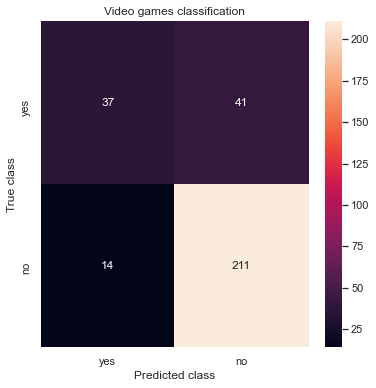

In [47]:
labels=["yes","no"]

cm=confusion_matrix(y_test, y_pred, labels=labels)
sns.set(style='whitegrid', palette='bright', font_scale=1)
plt.rcParams['figure.figsize'] = 14, 8
plt.figure(figsize=(6, 6))
sns_plot=sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Video games classification")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
yhat = best_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = yhat[:, 1]
# calculate scores
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
#print('No Skill: ROC AUC=%.3f' % (ns_auc))
#print([label] + ': ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs, pos_label="yes")
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs, pos_label="yes")
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label=label)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
# Plot Precision/ Recall graph
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs, pos_label=  'yes')
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label=label)
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
test_df

In [ ]:
label